In [15]:
import os

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


In [2]:
def prep_cesm_data(ds):
    ds['time'] = ds['time_bnds'][:,0]
    ds = ds.set_coords(['time_bnds'])
    return ds

In [96]:
dirname_root = '/glade/u/home/kheyblom/scratch/icesm_data/processed/'

freq = 'mon'
exp = 'iso-historical_r4'
# exp = 'iso-rcp85_r4-tag-b'
variables = [
    'PRECRC_H2Or',
    'PRECRC_HDOr',
    # 'PRECRC_LAT05Nr',
    'PRECRL_H2OR',
    'PRECRL_HDOR',
    # 'PRECRL_LAT05NR',
    ]

fileglob_fmt = {variable: os.path.join(
    dirname_root, 
    freq,
    exp,
    variable,
    f'{exp}.{variable}.{freq}.*.nc'
    ) for variable in variables}

ds_dict = {variable: xr.open_mfdataset(fileglob_fmt[variable],decode_times=True).load() for variable in variables}
ds_dict = {variable: prep_cesm_data(ds_dict[variable]) for variable in variables}

KeyError: 'PRECRL_LAT05NR'

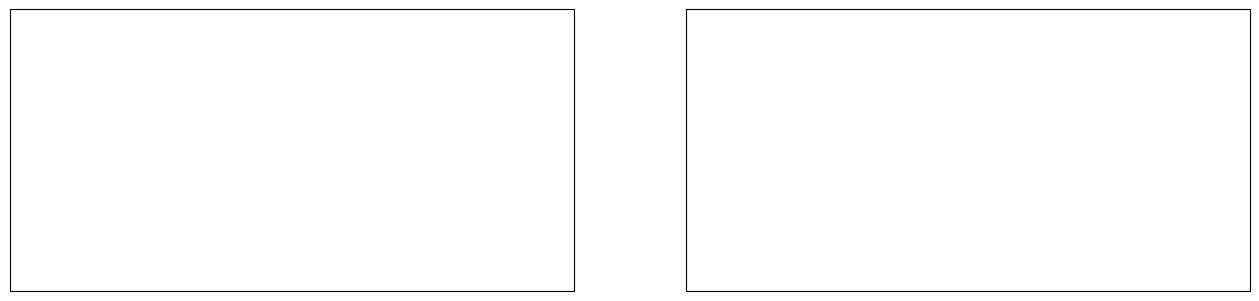

In [97]:
# variable = 'PRECRC_LAT05Nr'
variable = 'PRECRL_LAT05NR'

fig, axes = plt.subplots(
    ncols=2, figsize=(16,6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

stat_data = [
    (ds_dict[variable][variable].mean(dim='time'), 'Mean'),
    (ds_dict[variable][variable].std(dim='time'), 'Std Dev')
]

lats = ds_dict[variable]['lat']
lons = ds_dict[variable]['lon']

for ax, (data, label) in zip(axes, stat_data):
    mesh = ax.pcolormesh(
        lons, lats, data,
        transform=ccrs.PlateCarree(),
        cmap='viridis'
    )
    ax.coastlines(resolution='110m', linewidth=1)
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    cb = fig.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.07, fraction=0.08)
    cb.set_label(ds_dict[variable][variable].attrs['units'])
    ax.set_title(f'{variable} ({label})', fontsize=14)

plt.tight_layout()
plt.show()


# Compute weighted global mean and stddev (area weighted by cos(lat))
weights = np.cos(np.deg2rad(ds_dict[variable]['lat']))
weights = weights / weights.mean()  # Normalize weights

# Weighted spatial mean and stddev for each timestep
weighted_mean = (ds_dict[variable][variable] * weights).mean(dim=['lat', 'lon'])
weighted_std = (((ds_dict[variable][variable] - (ds_dict[variable][variable] * weights).mean(dim=['lat','lon']))**2 * weights).mean(dim=['lat','lon']))**0.5

global_stats = [
    (weighted_mean, 'Global Mean'),
    (weighted_std, 'Global Std Dev')
]

fig, axes = plt.subplots(ncols=2, figsize=(16,4))

for ax, (data, label) in zip(axes, global_stats):
    ax.plot(data.values)
    ax.set_ylabel(ds_dict[variable][variable].attrs['units'])
    ax.set_title(f"{variable} {label}")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


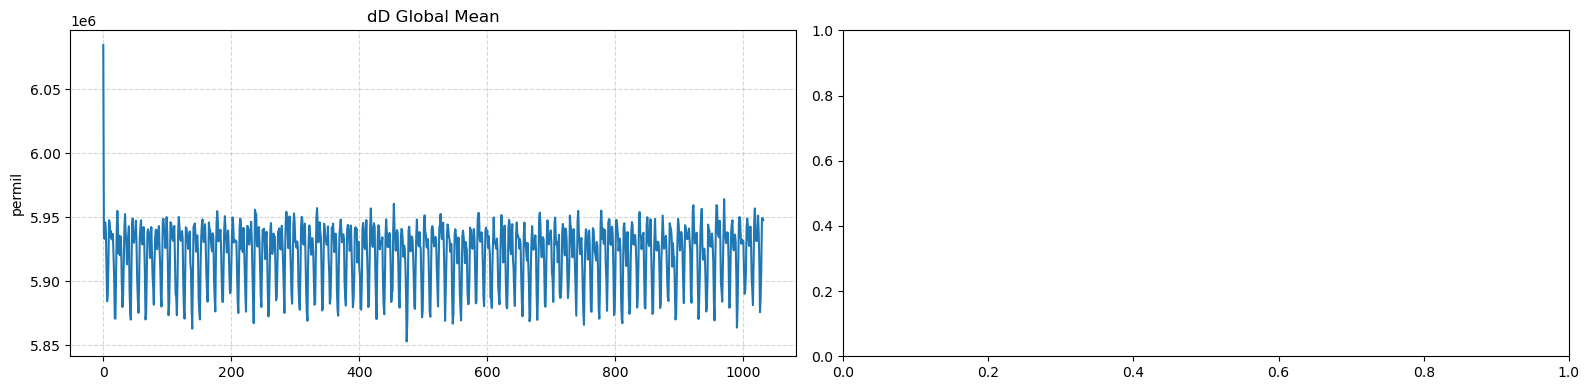

In [98]:
# R = ds_dict['PRECRC_HDOr']['PRECRC_HDOr'].mean(['lat','lon']) / ds_dict['PRECRC_H2Or']['PRECRC_H2Or'].mean(['lat','lon'])
R = ds_dict['PRECRL_HDOR']['PRECRL_HDOR'].mean(['lat','lon']) / ds_dict['PRECRL_H2OR']['PRECRL_H2OR'].mean(['lat','lon'])
R_ref = 1.5576e-4

dD = (R/R_ref - 1) * 1000

global_stats = [
    (dD, 'Global Mean'),
]

fig, axes = plt.subplots(ncols=2, figsize=(16,4))

for ax, (data, label) in zip(axes, global_stats):
    ax.plot(data.values)
    ax.set_ylabel('permil')
    ax.set_title(f"dD {label}")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [73]:
R.mean()

/glade/u/home/kheyblom/miniconda3/envs/icesm_general_analysis/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<xarray.DataArray ()> Size: 4B
array(nan, dtype=float32)
Attributes:
    units:         m/s
    cell_methods:  time: mean

In [69]:
dD

<xarray.DataArray (time: 288, lat: 192, lon: 288)> Size: 64MB
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
...
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]],
      shape=(288, 192, 288), dtype=float32)
Coordinates:
  * time     (time) object 2kB 2006-01-01 00:00:00 ... 2029-12-01 00:00:00
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    units:         m/s
    cell_methods:  time: mean